# First Floor Height Feature Selection

Exploring the NYC Building Elevation and Subgrade (BES) Data Set in Python  

Author: Mark Bauer

In [1]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import duckdb
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error

plt.rcParams['savefig.facecolor'] = 'white'
%matplotlib inline

In [2]:
# Printing verions of Python modules and packages with **watermark** - the IPython magic extension.
%reload_ext watermark
%watermark -v -p pandas,matplotlib,seaborn

Python implementation: CPython
Python version       : 3.8.13
IPython version      : 8.4.0

pandas    : 1.4.3
matplotlib: 3.5.2
seaborn   : 0.11.2



# Dataset: Building Elevation and Subgrade (BES)

In [3]:
# create a DuckDB database instance
con = duckdb.connect()

# examine count of rows
con.sql("SELECT COUNT(*) AS count_rows FROM read_parquet('data/bes-data.parquet')").show()

┌────────────┐
│ count_rows │
│   int64    │
├────────────┤
│     861876 │
└────────────┘



In [4]:
bes_df = con.sql("SELECT * FROM read_parquet('data/bes-data.parquet')").df()

rows, cols = bes_df.shape
print('rows: {:,}\ncolumns: {}'.format(rows, cols))

# preview data
bes_df.head()

rows: 861,876
columns: 26


,the_geom,bin,bbl,borough,block,lot,address,z_grade,z_floor,subgrade,...,longitude,pluto_bbl,Council,BoroCD,CTLabel,BoroCT2020,NTA2020,NTAName,CDTA2020,CDTAName
0,POINT (-74.22274561187417 40.52134422844183),5128004,5075340353,5.0,7534.0,353,78 SAVO LOOP,29.428,32.332,N,...,-74.222746,5075340353,51,503,226.01,5022601,SI0304,Annadale-Huguenot-Prince's Bay-Woodrow,SI03,SI03 South Shore (CD 3 Approximation)
1,POINT (-74.24179250549321 40.52875316810818),5155392,5075960125,5.0,7596.0,125,72 CHART LOOP,25.366,26.703,N,...,-74.241793,5075960125,51,503,226.02,5022602,SI0305,Tottenville-Charleston,SI03,SI03 South Shore (CD 3 Approximation)
2,POINT (-74.24109012652094 40.528883822921635),5148808,5075960131,5.0,7596.0,131,40 TIDES LANE,36.172,38.902,N,...,-74.241090,5075960131,51,503,226.02,5022602,SI0305,Tottenville-Charleston,SI03,SI03 South Shore (CD 3 Approximation)
3,POINT (-74.24649640323727 40.507045708438184),5088274,5079150042,5.0,7915.0,42,328 MAIN STREET,69.897,72.459,N,...,-74.246496,5079150042,51,503,244.01,5024401,SI0305,Tottenville-Charleston,SI03,SI03 South Shore (CD 3 Approximation)
4,POINT (-74.24198032271697 40.51005666426356),5087850,5078680123,5.0,7868.0,123,309 SLEIGHT AVENUE,74.907,79.122,N,...,-74.241980,5078680123,51,503,244.01,5024401,SI0305,Tottenville-Charleston,SI03,SI03 South Shore (CD 3 Approximation)


`z_grade`: The elevation of the building at it's lowest adjacent grade - the lowest point where the building touches the ground.

`z_floor`: The elevation of what is estimated to be the lowest actively used floor.

Definitions from the data dictionary.

In [5]:
bes_df = (
    bes_df
    .loc[
        (bes_df['z_floor'] != 0)
        & (bes_df['z_grade'] != 0)
        & (bes_df['notes1'] == 'Property was Successfully Measured')]
    .reset_index(drop=True)
)

print('new shape of data:', bes_df.shape)
bes_df.head()

new shape of data: (646781, 26)


,the_geom,bin,bbl,borough,block,lot,address,z_grade,z_floor,subgrade,...,longitude,pluto_bbl,Council,BoroCD,CTLabel,BoroCT2020,NTA2020,NTAName,CDTA2020,CDTAName
0,POINT (-74.22274561187417 40.52134422844183),5128004,5075340353,5.0,7534.0,353,78 SAVO LOOP,29.428,32.332,N,...,-74.222746,5075340353,51,503,226.01,5022601,SI0304,Annadale-Huguenot-Prince's Bay-Woodrow,SI03,SI03 South Shore (CD 3 Approximation)
1,POINT (-74.24179250549321 40.52875316810818),5155392,5075960125,5.0,7596.0,125,72 CHART LOOP,25.366,26.703,N,...,-74.241793,5075960125,51,503,226.02,5022602,SI0305,Tottenville-Charleston,SI03,SI03 South Shore (CD 3 Approximation)
2,POINT (-74.24109012652094 40.528883822921635),5148808,5075960131,5.0,7596.0,131,40 TIDES LANE,36.172,38.902,N,...,-74.241090,5075960131,51,503,226.02,5022602,SI0305,Tottenville-Charleston,SI03,SI03 South Shore (CD 3 Approximation)
3,POINT (-74.24649640323727 40.507045708438184),5088274,5079150042,5.0,7915.0,42,328 MAIN STREET,69.897,72.459,N,...,-74.246496,5079150042,51,503,244.01,5024401,SI0305,Tottenville-Charleston,SI03,SI03 South Shore (CD 3 Approximation)
4,POINT (-74.24198032271697 40.51005666426356),5087850,5078680123,5.0,7868.0,123,309 SLEIGHT AVENUE,74.907,79.122,N,...,-74.241980,5078680123,51,503,244.01,5024401,SI0305,Tottenville-Charleston,SI03,SI03 South Shore (CD 3 Approximation)


Calculating Height from Building Adjacent Grade to First Floor.

In [6]:
# height from building floor to grade
bes_df['z_floor_grade'] = bes_df['z_floor'] - bes_df['z_grade']

# summary stats
bes_df['z_floor_grade'].describe()

count    646781.000000
mean          3.834224
std           2.880029
min          -8.832000
25%           1.671000
50%           3.365000
75%           5.009000
max          83.759000
Name: z_floor_grade, dtype: float64

# Dataset: NYC Building Footprints

In [7]:
path = "https://data.cityofnewyork.us/api/views/qb5r-6dgf/rows.csv?accessType=DOWNLOAD"
buildings_df = pd.read_csv(path, low_memory=False)

rows, cols = buildings_df.shape
print('rows: {:,}\ncolumns: {}'.format(rows, cols))

# preview data
buildings_df.head()

rows: 1,083,074
columns: 16


,the_geom,NAME,BIN,CNSTRCT_YR,LSTMODDATE,LSTSTATYPE,DOITT_ID,HEIGHTROOF,FEAT_CODE,GROUNDELEV,SHAPE_AREA,SHAPE_LEN,BASE_BBL,MPLUTO_BBL,GEOMSOURCE,GLOBALID
0,MULTIPOLYGON (((-73.96664570466969 40.62599676...,NaN,3170958,1925.0,08/22/2017 12:00:00 AM,Constructed,96807,29.749853,2100,40.0,0,0,3065220021,3065220021,Photogramm,{31298F86-3088-4F53-B3DB-71A9EFA6FA1F}
1,MULTIPOLYGON (((-74.16790202462265 40.63936048...,NaN,5028452,1965.0,08/22/2017 12:00:00 AM,Constructed,326368,22.630000,2100,39.0,0,0,5012640036,5012640036,Photogramm,{F5F8CDA5-69E2-46F8-8F69-BA95C025B520}
2,MULTIPOLYGON (((-74.19510813278613 40.55610681...,NaN,5078368,1970.0,08/22/2017 12:00:00 AM,Constructed,746627,35.760000,2100,51.0,0,0,5060190091,5060190091,Photogramm,{9F644794-F72C-4582-9E5E-B337E2B97068}
3,MULTIPOLYGON (((-73.96113466505085 40.57743931...,NaN,3245111,1928.0,08/22/2017 12:00:00 AM,Constructed,786626,37.500000,2100,6.0,0,0,3086910048,3086910048,Photogramm,{F916B22D-E25B-44AE-9FA9-2A51191B9CDF}
4,MULTIPOLYGON (((-73.75421559146166 40.75591276...,NaN,4161096,1950.0,08/22/2017 12:00:00 AM,Constructed,746409,18.015113,2100,93.0,0,0,4075020005,4075020005,Photogramm,{525F2C24-616B-4F29-98A3-8FEA5D4B1A7D}


In [8]:
buildings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1083074 entries, 0 to 1083073
Data columns (total 16 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   the_geom    1083074 non-null  object 
 1   NAME        2254 non-null     object 
 2   BIN         1083074 non-null  int64  
 3   CNSTRCT_YR  1072806 non-null  float64
 4   LSTMODDATE  1083074 non-null  object 
 5   LSTSTATYPE  1082746 non-null  object 
 6   DOITT_ID    1083074 non-null  int64  
 7   HEIGHTROOF  1080494 non-null  float64
 8   FEAT_CODE   1083074 non-null  int64  
 9   GROUNDELEV  1082522 non-null  float64
 10  SHAPE_AREA  1083074 non-null  int64  
 11  SHAPE_LEN   1083074 non-null  int64  
 12  BASE_BBL    1083074 non-null  int64  
 13  MPLUTO_BBL  1083074 non-null  int64  
 14  GEOMSOURCE  1082778 non-null  object 
 15  GLOBALID    1083074 non-null  object 
dtypes: float64(3), int64(7), object(6)
memory usage: 132.2+ MB


# Dataset: NYC PLUTO

In [9]:
path = "https://data.cityofnewyork.us/api/views/64uk-42ks/rows.csv?accessType=DOWNLOAD"
pluto_df = pd.read_csv(path, low_memory=False)

rows, cols = pluto_df.shape
print('rows: {:,}\ncolumns: {}'.format(rows, cols))

# preview data
pluto_df.head()

rows: 858,572
columns: 101


,borough,block,lot,community board,census tract 2010,cb2010,schooldist,council district,postcode,firecomp,...,landmkdate,basempdate,masdate,polidate,edesigdate,geom,dcpedited,notes,bct2020,bctcb2020
0,QN,798,31,401.0,123.01,2006.0,30.0,22.0,11105.0,E263,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4012301.0,4.012301e+10
1,BK,6429,16,311.0,172.00,2004.0,20.0,50.0,11228.0,L149,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3017200.0,3.017200e+10
2,BK,7790,42,318.0,732.00,1004.0,22.0,45.0,11210.0,L159,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3073200.0,3.073200e+10
3,BK,7197,52,315.0,374.01,2000.0,21.0,47.0,11223.0,E245,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3037401.0,3.037401e+10
4,QN,15318,35,414.0,1072.01,1032.0,27.0,32.0,11693.0,E266,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4107201.0,4.107201e+10


In [10]:
pluto_df['firm07_flag'] = pluto_df['firm07_flag'].fillna(0)
pluto_df['pfirm15_flag'] = pluto_df['pfirm15_flag'].fillna(0)

pluto_df.head()

,borough,block,lot,community board,census tract 2010,cb2010,schooldist,council district,postcode,firecomp,...,landmkdate,basempdate,masdate,polidate,edesigdate,geom,dcpedited,notes,bct2020,bctcb2020
0,QN,798,31,401.0,123.01,2006.0,30.0,22.0,11105.0,E263,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4012301.0,4.012301e+10
1,BK,6429,16,311.0,172.00,2004.0,20.0,50.0,11228.0,L149,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3017200.0,3.017200e+10
2,BK,7790,42,318.0,732.00,1004.0,22.0,45.0,11210.0,L159,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3073200.0,3.073200e+10
3,BK,7197,52,315.0,374.01,2000.0,21.0,47.0,11223.0,E245,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3037401.0,3.037401e+10
4,QN,15318,35,414.0,1072.01,1032.0,27.0,32.0,11693.0,E266,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4107201.0,4.107201e+10


# Merge datasets into one dataframe

In [11]:
merged_df = (
    bes_df
    .loc[:, ['bin', 'pluto_bbl', 'z_floor_grade']]
    .merge(
        buildings_df,
        left_on='bin',
        right_on='BIN')
    .merge(
        pluto_df,
        left_on='pluto_bbl',
        right_on='bbl')
)

rows, cols = merged_df.shape
print('rows: {:,}\ncolumns: {}'.format(rows, cols))

merged_df.head()

rows: 644,604
columns: 120


,bin,pluto_bbl,z_floor_grade,the_geom,NAME,BIN,CNSTRCT_YR,LSTMODDATE,LSTSTATYPE,DOITT_ID,...,landmkdate,basempdate,masdate,polidate,edesigdate,geom,dcpedited,notes,bct2020,bctcb2020
0,5128004,5075340353,2.904,MULTIPOLYGON (((-74.22271476516362 40.52128189...,NaN,5128004,1997.0,08/22/2017 12:00:00 AM,Constructed,651794,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5022601.0,5.022601e+10
1,5155392,5075960125,1.337,MULTIPOLYGON (((-74.24172734197434 40.52880752...,NaN,5155392,2007.0,08/22/2017 12:00:00 AM,Constructed,1101303,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5022602.0,5.022602e+10
2,5148808,5075960131,2.730,MULTIPOLYGON (((-74.24102137299579 40.52884545...,NaN,5148808,2007.0,08/22/2017 12:00:00 AM,Constructed,1101293,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5022602.0,5.022602e+10
3,5088274,5079150042,2.562,MULTIPOLYGON (((-74.24641599963033 40.50699198...,NaN,5088274,1980.0,08/22/2017 12:00:00 AM,Constructed,515135,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5024401.0,5.024401e+10
4,5087850,5078680123,4.215,MULTIPOLYGON (((-74.24200532507773 40.51000156...,NaN,5087850,1996.0,08/22/2017 12:00:00 AM,Constructed,405357,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5024401.0,5.024401e+10


In [12]:
ser = merged_df.isnull().sum().div(merged_df.shape[0])
cols = ser.loc[ser < .50].index.to_list()

merged_df = merged_df.loc[:, cols]
rows, cols = merged_df.shape
print('rows: {:,}\ncolumns: {}'.format(rows, cols))

merged_df.head()

rows: 644,604
columns: 91


,bin,pluto_bbl,z_floor_grade,the_geom,BIN,CNSTRCT_YR,LSTMODDATE,LSTSTATYPE,DOITT_ID,HEIGHTROOF,...,sanborn,taxmap,plutomapid,version,sanitdistrict,healthcenterdistrict,firm07_flag,pfirm15_flag,bct2020,bctcb2020
0,5128004,5075340353,2.904,MULTIPOLYGON (((-74.22271476516362 40.52128189...,5128004,1997.0,08/22/2017 12:00:00 AM,Constructed,651794,24.683095,...,505 521,53001.0,1,24v1.1,3.0,51.0,0.0,0.0,5022601.0,5.022601e+10
1,5155392,5075960125,1.337,MULTIPOLYGON (((-74.24172734197434 40.52880752...,5155392,2007.0,08/22/2017 12:00:00 AM,Constructed,1101303,32.000000,...,505 564,53001.0,1,24v1.1,3.0,51.0,0.0,0.0,5022602.0,5.022602e+10
2,5148808,5075960131,2.730,MULTIPOLYGON (((-74.24102137299579 40.52884545...,5148808,2007.0,08/22/2017 12:00:00 AM,Constructed,1101293,34.000000,...,505 564,53001.0,1,24v1.1,3.0,51.0,0.0,0.0,5022602.0,5.022602e+10
3,5088274,5079150042,2.562,MULTIPOLYGON (((-74.24641599963033 40.50699198...,5088274,1980.0,08/22/2017 12:00:00 AM,Constructed,515135,24.420000,...,505 531,53201.0,1,24v1.1,3.0,51.0,0.0,0.0,5024401.0,5.024401e+10
4,5087850,5078680123,4.215,MULTIPOLYGON (((-74.24200532507773 40.51000156...,5087850,1996.0,08/22/2017 12:00:00 AM,Constructed,405357,31.410000,...,505 531,53201.0,1,24v1.1,3.0,51.0,0.0,0.0,5024401.0,5.024401e+10


In [13]:
cols_drop = [
    'LSTMODDATE', 'bin', 'BIN', 'the_geom', 'LSTMODDATE', 'DOITT_ID',
    'SHAPE_AREA', 'SHAPE_LEN', 'GLOBALID', 'address', 'ownername',
    'sanborn', 'taxmap', 'plutomapid', 'version', 'zonemap',
]

merged_df = merged_df.drop(columns=cols_drop)

merged_df.head()

,pluto_bbl,z_floor_grade,CNSTRCT_YR,LSTSTATYPE,HEIGHTROOF,FEAT_CODE,GROUNDELEV,BASE_BBL,MPLUTO_BBL,GEOMSOURCE,...,xcoord,ycoord,latitude,longitude,sanitdistrict,healthcenterdistrict,firm07_flag,pfirm15_flag,bct2020,bctcb2020
0,5075340353,2.904,1997.0,Constructed,24.683095,2100,30.0,5075340353,5075340353,Photogramm,...,922320.0,129288.0,40.521325,-74.222751,3.0,51.0,0.0,0.0,5022601.0,5.022601e+10
1,5075960125,1.337,2007.0,Constructed,32.000000,2100,29.0,5075960125,5075960125,Other (Man,...,917024.0,132018.0,40.528779,-74.241827,3.0,51.0,0.0,0.0,5022602.0,5.022602e+10
2,5075960131,2.730,2007.0,Constructed,34.000000,2100,34.0,5075960131,5075960131,Other (Man,...,917221.0,132058.0,40.528891,-74.241118,3.0,51.0,0.0,0.0,5022602.0,5.022602e+10
3,5079150042,2.562,1980.0,Constructed,24.420000,2100,71.0,5079150042,5079150042,Photogramm,...,915705.0,124102.0,40.507041,-74.246491,3.0,51.0,0.0,0.0,5024401.0,5.024401e+10
4,5078680123,4.215,1996.0,Constructed,31.410000,2100,75.0,5078680123,5078680123,Photogramm,...,917021.0,125217.0,40.510112,-74.241770,3.0,51.0,0.0,0.0,5024401.0,5.024401e+10


In [14]:
cols = ['CNSTRCT_YR', 'yearbuilt', 'yearalter1', 'yearalter2']

for col in cols:
    merged_df.loc[merged_df[col] == 0, col] == np.nan

In [15]:
dtypes = {
    'FEAT_CODE': 'str',
    'landuse':'str',
    'proxcode':'str',
    'lottype':'str',
    'bsmtcode':'str',
    'firm07_flag':'str',
    'pfirm15_flag':'str',
    'pluto_bbl':'str',
    'BASE_BBL':'str',
    'MPLUTO_BBL':'str',
    'block':'str',
    'lot':'str',
    'community board':'str',
    'census tract 2010':'str',
    'cb2010':'str',
    'schooldist':'str',
    'council district':'str',
    'postcode':'str',
    'policeprct':'str',
    'sanitboro':'str',
    'borocode':'str',
    'bbl':'str',
    'tract2010':'str',
    'sanitdistrict':'str',
    'healthcenterdistrict':'str',
    'bct2020':'str',
    'bctcb2020':'str'    
}

merged_df = merged_df.astype(dtypes)

merged_df.head()

,pluto_bbl,z_floor_grade,CNSTRCT_YR,LSTSTATYPE,HEIGHTROOF,FEAT_CODE,GROUNDELEV,BASE_BBL,MPLUTO_BBL,GEOMSOURCE,...,xcoord,ycoord,latitude,longitude,sanitdistrict,healthcenterdistrict,firm07_flag,pfirm15_flag,bct2020,bctcb2020
0,5075340353,2.904,1997.0,Constructed,24.683095,2100,30.0,5075340353,5075340353,Photogramm,...,922320.0,129288.0,40.521325,-74.222751,3.0,51.0,0.0,0.0,5022601.0,50226014000.0
1,5075960125,1.337,2007.0,Constructed,32.000000,2100,29.0,5075960125,5075960125,Other (Man,...,917024.0,132018.0,40.528779,-74.241827,3.0,51.0,0.0,0.0,5022602.0,50226022005.0
2,5075960131,2.730,2007.0,Constructed,34.000000,2100,34.0,5075960131,5075960131,Other (Man,...,917221.0,132058.0,40.528891,-74.241118,3.0,51.0,0.0,0.0,5022602.0,50226022008.0
3,5079150042,2.562,1980.0,Constructed,24.420000,2100,71.0,5079150042,5079150042,Photogramm,...,915705.0,124102.0,40.507041,-74.246491,3.0,51.0,0.0,0.0,5024401.0,50244011002.0
4,5078680123,4.215,1996.0,Constructed,31.410000,2100,75.0,5078680123,5078680123,Photogramm,...,917021.0,125217.0,40.510112,-74.241770,3.0,51.0,0.0,0.0,5024401.0,50244012005.0


# All Land Uses

In [16]:
%%time

categorical_columns = (
    merged_df
    .select_dtypes(exclude='number')
    .columns
    .to_list()
)

numerical_columns = (
    merged_df
    .drop(columns=['z_floor_grade'])
    .select_dtypes(include='number')
    .columns
    .to_list()
)

X = merged_df[numerical_columns + categorical_columns]
y = merged_df['z_floor_grade']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

categorical_transformer = Pipeline(
    steps=[("encoder", OneHotEncoder(handle_unknown="ignore"))]
)
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler())]
)

preprocessing = ColumnTransformer([
        ("cat", categorical_transformer, categorical_columns),
        ("num", numeric_transformer, numerical_columns)],
    verbose_feature_names_out=False,
)

rf = Pipeline([
    ("preprocess", preprocessing),
    ("classifier", RandomForestRegressor(random_state=42, max_depth=5, n_jobs=-1))]
)

rf.fit(X_train, y_train)

CPU times: user 40min 3s, sys: 8.17 s, total: 40min 11s
Wall time: 7min 17s


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['pluto_bbl', 'LSTSTATYPE',
                                                   'FEAT_CODE', 'BASE_BBL',
                                                   'MPLUTO_BBL', 'GEOMSOURCE',
                                                   'borough', 'block', 'lot',
                                                   'community board',
                                                   'census tract 2010',
                                                   'cb2010', 'schooldist',
                                                   'council district',
                                                   'postcode', 'firecomp',
                                                   'policeprct', 'sa...
                                                   'retailarea', 'garagearea',
                                                   'strgearea', 'factryarea',
                                                   'otherarea', 'areasource',
                                                   'numbldgs', 'numfloors',
                                                   'unitsres', 'unitstotal',
                                                   'lotfront', 'lotdepth',
                                                   'bldgfront', 'bldgdepth',
                                                   'assessland', 'assesstot',
                                                   'exempttot', 'yearbuilt',
                                                   'yearalter1', 'yearalter2', ...])],
                                   verbose_feature_names_out=False)),
                ('classifier',
                 RandomForestRegressor(max_depth=5, n_jobs=-1,
                                       random_state=42))])

In [17]:
print(f"RF train accuracy r-squared: {rf.score(X_train, y_train):.3f}")
print(f"RF test accuracy r-squared: {rf.score(X_test, y_test):.3f}")
print(f"RMSE: {mean_squared_error(y_test, rf.predict(X_test), squared=False):.3f}")

RF train accuracy r-squared: 0.280
RF test accuracy r-squared: 0.273
RMSE: 2.462


In [18]:
y_pred = pd.Series(rf.predict(X_test), name='y_pred')
evaluate_df = pd.concat(
    [y_test.reset_index(drop=True).rename('y_test'), y_pred],
    axis=1
)

evaluate_df['residuals'] = evaluate_df['y_test'] - evaluate_df['y_pred']

evaluate_df

,y_test,y_pred,residuals
0,4.112,3.821679,0.290321
1,8.009,7.455483,0.553517
2,8.275,6.744138,1.530862
3,2.985,4.181490,-1.196490
4,4.188,3.428817,0.759183
...,...,...,...
161146,5.422,5.182114,0.239886
161147,2.770,4.174752,-1.404752
161148,9.436,4.174752,5.261248
161149,2.839,3.428817,-0.589817


In [19]:
evaluate_df.describe()

,y_test,y_pred,residuals
count,161151.000000,161151.000000,161151.000000
mean,3.831730,3.840889,-0.009158
std,2.888553,1.484727,2.462258
min,-8.832000,0.803285,-12.997169
25%,1.671000,3.211405,-1.155752
50%,3.363000,3.821679,-0.252679
75%,4.988000,4.174752,0.892491
max,82.511000,9.246116,76.939942


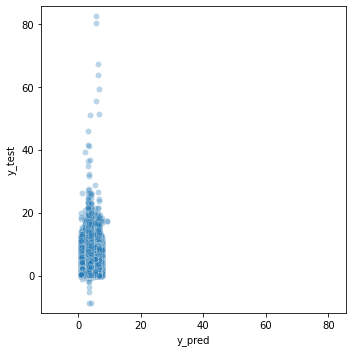

In [20]:
fig, ax = plt.subplots(figsize=(5, 5))

sns.scatterplot(
    data=evaluate_df,
    y='y_test',
    x='y_pred',
    ax=ax,
    alpha=.3
)

right = evaluate_df.iloc[:,:-1].max().max() + 3
left = evaluate_df.iloc[:,:-1].min().min() - 3
ax.set_xlim(left, right)
ax.set_ylim(left, right)

plt.tight_layout()

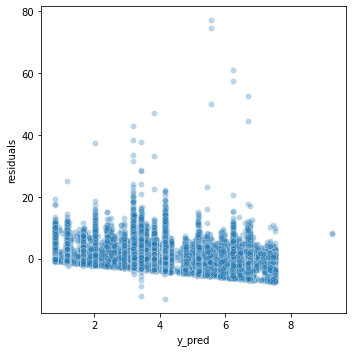

In [21]:
fig, ax = plt.subplots(figsize=(5, 5))

sns.scatterplot(
    data=evaluate_df,
    y='residuals',
    x='y_pred',
    ax=ax,
    alpha=.3
)

plt.tight_layout()

## All Land Uses: Feature importance based on Mean Decrease in Impurity (MDI)
Source: https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py

Further reading: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

In [22]:
feature_names = rf[:-1].get_feature_names_out()

mdi_importances = (
    pd
    .Series(rf[-1].feature_importances_, index=feature_names)
    .sort_values(ascending=True)
    .tail(20)
)

mdi_importances

bct2020_4138501.0    0.001704
yearbuilt            0.002650
ycoord               0.002878
latitude             0.003473
lotfront             0.004038
bct2020_4089201.0    0.004887
commfar              0.005536
bldgclass_A5         0.006508
bsmtcode_2.0         0.007275
numbldgs             0.008086
bsmtcode_5.0         0.010652
resarea              0.012159
CNSTRCT_YR           0.014665
lotarea              0.015979
numfloors            0.016664
retailarea           0.024506
healtharea           0.026592
HEIGHTROOF           0.045977
comarea              0.249632
bsmtcode_1.0         0.512308
dtype: float64

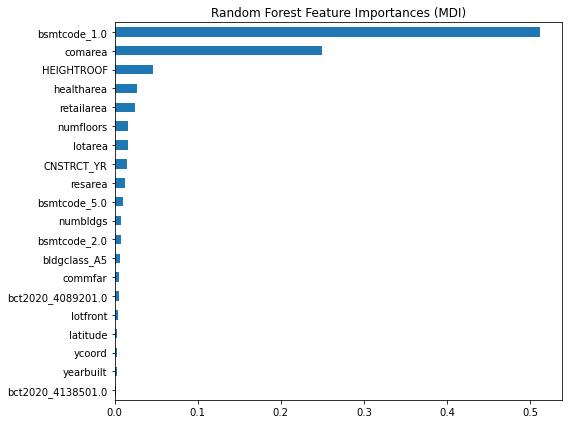

In [23]:
fig, ax = plt.subplots(figsize=(8, 6))

mdi_importances.plot.barh(ax=ax)

plt.title("Random Forest Feature Importances (MDI)")
plt.tight_layout()

# Residential Land Use Only

In [24]:
residential_df = (
    merged_df
    .loc[merged_df['landuse'].isin(['1.0', '2.0', '3.0'])]
    .reset_index(drop=True)
)

rows, cols = residential_df.shape
print('rows: {:,}\ncolumns: {}'.format(rows, cols))

rows: 557,925
columns: 76


In [25]:
%%time

categorical_columns = (
    residential_df
    .select_dtypes(exclude='number')
    .columns
    .to_list()
)

numerical_columns = (
    residential_df
    .drop(columns=['z_floor_grade'])
    .select_dtypes(include='number')
    .columns
    .to_list()
)

X = residential_df[numerical_columns + categorical_columns]
y = residential_df['z_floor_grade']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

categorical_transformer = Pipeline(
    steps=[("encoder", OneHotEncoder(handle_unknown="ignore"))]
)
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler())]
)

preprocessing = ColumnTransformer([
        ("cat", categorical_transformer, categorical_columns),
        ("num", numeric_transformer, numerical_columns)],
    verbose_feature_names_out=False,
)

rf = Pipeline([
    ("preprocess", preprocessing),
    ("classifier", RandomForestRegressor(random_state=42, max_depth=5, n_jobs=-1))]
)

rf.fit(X_train, y_train)

CPU times: user 32min 36s, sys: 5.19 s, total: 32min 41s
Wall time: 4min 36s


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['pluto_bbl', 'LSTSTATYPE',
                                                   'FEAT_CODE', 'BASE_BBL',
                                                   'MPLUTO_BBL', 'GEOMSOURCE',
                                                   'borough', 'block', 'lot',
                                                   'community board',
                                                   'census tract 2010',
                                                   'cb2010', 'schooldist',
                                                   'council district',
                                                   'postcode', 'firecomp',
                                                   'policeprct', 'sa...
                                                   'retailarea', 'garagearea',
                                                   'strgearea', 'factryarea',
                                                   'otherarea', 'areasource',
                                                   'numbldgs', 'numfloors',
                                                   'unitsres', 'unitstotal',
                                                   'lotfront', 'lotdepth',
                                                   'bldgfront', 'bldgdepth',
                                                   'assessland', 'assesstot',
                                                   'exempttot', 'yearbuilt',
                                                   'yearalter1', 'yearalter2', ...])],
                                   verbose_feature_names_out=False)),
                ('classifier',
                 RandomForestRegressor(max_depth=5, n_jobs=-1,
                                       random_state=42))])

In [26]:
print(f"RF train accuracy r-squared: {rf.score(X_train, y_train):.3f}")
print(f"RF test accuracy r-squared: {rf.score(X_test, y_test):.3f}")
print(f"RMSE: {mean_squared_error(y_test, rf.predict(X_test), squared=False):.3f}")

RF train accuracy r-squared: 0.221
RF test accuracy r-squared: 0.215
RMSE: 2.448


In [27]:
y_pred = pd.Series(rf.predict(X_test), name='y_pred')
evaluate_df = pd.concat(
    [y_test.reset_index(drop=True).rename('y_test'), y_pred],
    axis=1
)

evaluate_df['residuals'] = evaluate_df['y_test'] - evaluate_df['y_pred']

evaluate_df

,y_test,y_pred,residuals
0,0.224,2.900518,-2.676518
1,3.519,3.807297,-0.288297
2,9.201,1.671021,7.529979
3,3.086,3.263966,-0.177966
4,3.817,3.373654,0.443346
...,...,...,...
139477,3.284,3.898065,-0.614065
139478,4.057,4.197356,-0.140356
139479,3.290,3.397315,-0.107315
139480,2.914,2.900518,0.013482


In [28]:
evaluate_df.describe()

,y_test,y_pred,residuals
count,139482.000000,139482.000000,139482.000000
mean,4.210855,4.209754,0.001102
std,2.762196,1.222375,2.447620
min,-8.832000,1.471624,-12.990484
25%,2.555000,3.373654,-1.250297
50%,3.585000,3.891635,-0.183065
75%,5.528750,4.197356,1.009690
max,55.490000,57.442014,46.116816


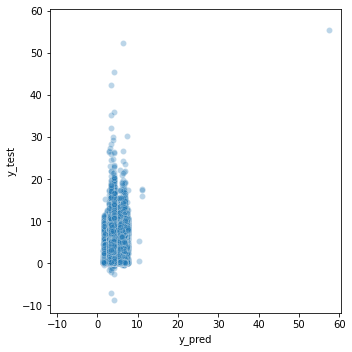

In [29]:
fig, ax = plt.subplots(figsize=(5, 5))

sns.scatterplot(
    data=evaluate_df,
    y='y_test',
    x='y_pred',
    ax=ax,
    alpha=.3
)

right = evaluate_df.iloc[:,:-1].max().max() + 3
left = evaluate_df.iloc[:,:-1].min().min() - 3
ax.set_xlim(left, right)
ax.set_ylim(left, right)

plt.tight_layout()

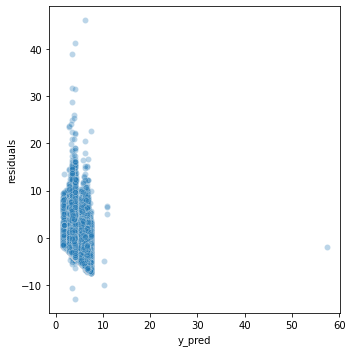

In [30]:
fig, ax = plt.subplots(figsize=(5, 5))

sns.scatterplot(
    data=evaluate_df,
    y='residuals',
    x='y_pred',
    ax=ax,
    alpha=.3
)

plt.tight_layout()

## Residential Land Use Feature importance based on Mean Decrease in Impurity (MDI)
Source: https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py

Further reading: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

In [31]:
feature_names = rf[:-1].get_feature_names_out()

mdi_importances = (
    pd
    .Series(rf[-1].feature_importances_, index=feature_names)
    .sort_values(ascending=True)
    .tail(20)
)

mdi_importances

bsmtcode_5.0               0.003073
bct2020_4138501.0          0.003424
borough_BK                 0.003780
latitude                   0.003950
bct2020_4089201.0          0.005872
ycoord                     0.006687
resarea                    0.007188
bldgclass_A5               0.007892
ext_G                      0.009113
lotarea                    0.013521
numbldgs                   0.014323
lotfront                   0.015052
CNSTRCT_YR                 0.016145
yearbuilt                  0.017079
bctcb2020_10255001006.0    0.022749
bsmtcode_2.0               0.027970
healtharea                 0.043328
HEIGHTROOF                 0.053817
numfloors                  0.054965
bsmtcode_1.0               0.627194
dtype: float64

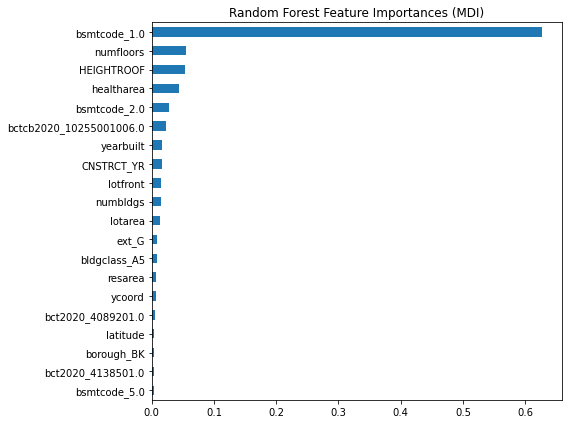

In [32]:
fig, ax = plt.subplots(figsize=(8, 6))

mdi_importances.plot.barh(ax=ax)

plt.title("Random Forest Feature Importances (MDI)")
plt.tight_layout()